In [11]:
# Import necessary libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## **2.1** Loading the Image

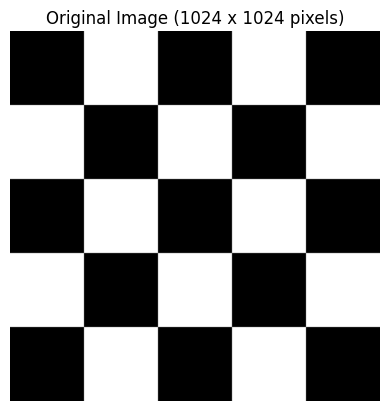

In [12]:
# Load the image
image_path = 'checkerboard.png'
image = Image.open(image_path).convert('L')
image_array = np.array(image)

plt.imshow(image, cmap='gray')
plt.title('Original Image (1024 x 1024 pixels)')	
plt.axis('off')
plt.show()

## **2.2** Histogram & Cumulative Probability Function

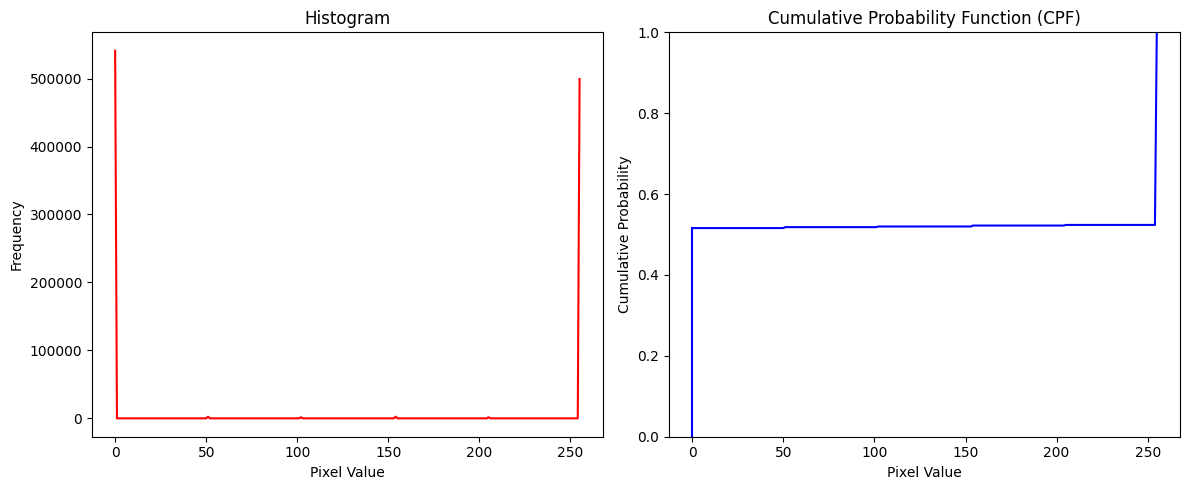

In [13]:
# Compute histogram
x, y = np.histogram(image_array, bins=256, range=(0, 255))

# Compute cumulative probability function (CPF)
cpf = np.cumsum(x) / np.sum(x)

# Plot histogram and CPF 
plt.figure(figsize=(12, 5))

# Histogram plot
plt.subplot(1, 2, 1)
plt.plot(x, color='red')
plt.title('Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# CPF plot
plt.subplot(1, 2, 2)
plt.plot(cpf, color='blue')
plt.plot([0, y[0]], [0, cpf[0]], color='blue', linestyle='-')
plt.title('Cumulative Probability Function (CPF)')
plt.xlabel('Pixel Value')
plt.ylabel('Cumulative Probability')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## **2.3** Low-Pass Filter in the Spatial Domain

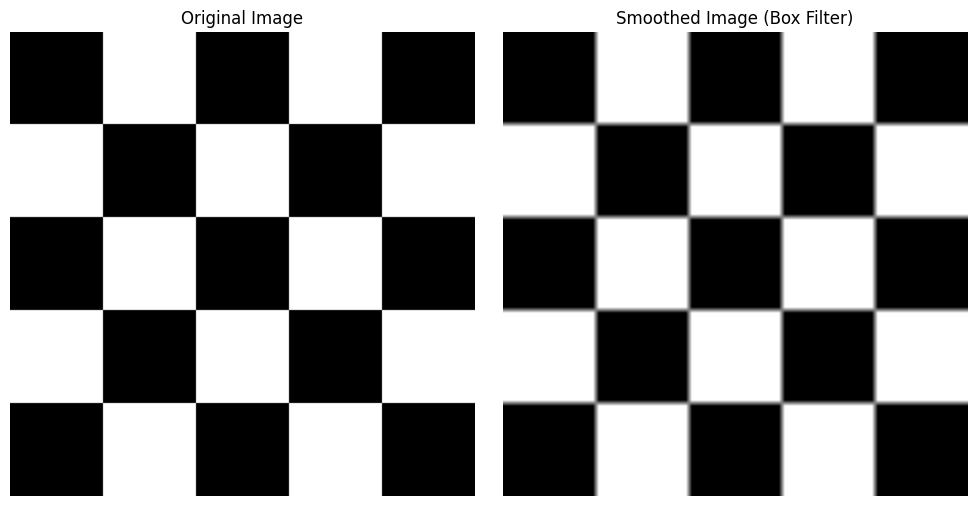

In [18]:
# Define a simple averaging (box blur) filter
def box_filter(image_array, kernel_size):
    # Create an averaging kernel
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    # Get image dimensions
    height, width = image_array.shape
    # Initialize the output image
    blurred_image = np.zeros_like(image_array)

    # Apply the averaging filter (convolution)
    pad = kernel_size // 2
    padded_image = np.pad(image_array, pad, mode='edge')  # Pad with edge values

    for i in range(height):
        for j in range(width):
            # Extract the region of interest
            region = padded_image[i:i + kernel_size, j:j + kernel_size]
            # Convolve (element-wise multiplication and sum)
            blurred_image[i, j] = np.sum(region * kernel)

    return blurred_image

# Apply the box blur with a 3x3 kernel
smoothed_image_sd = box_filter(image_array, 13)

# Plot the original and smoothed images side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Smoothed image (box blur)
plt.subplot(1, 2, 2)
plt.imshow(smoothed_image_sd, cmap='gray')
plt.title('Smoothed Image (Box Filter)')
plt.axis('off')

plt.tight_layout()
plt.show()

## **2.4** Explain if the low-pass filter you selected is separable

A box filter (or averaging filter) is separable, meaning that it can be broken down into the product of two 1D filters. The box filter typically has a kernel of size m x n, where each element has the same value (1/(m x n) to maintain the average). This kernel can be expressed as the outer product of two 1D vectors: one representing the row averaging and the other representing the column averaging.

## **2.5** Low-Pass Filter in the Frequency Domain

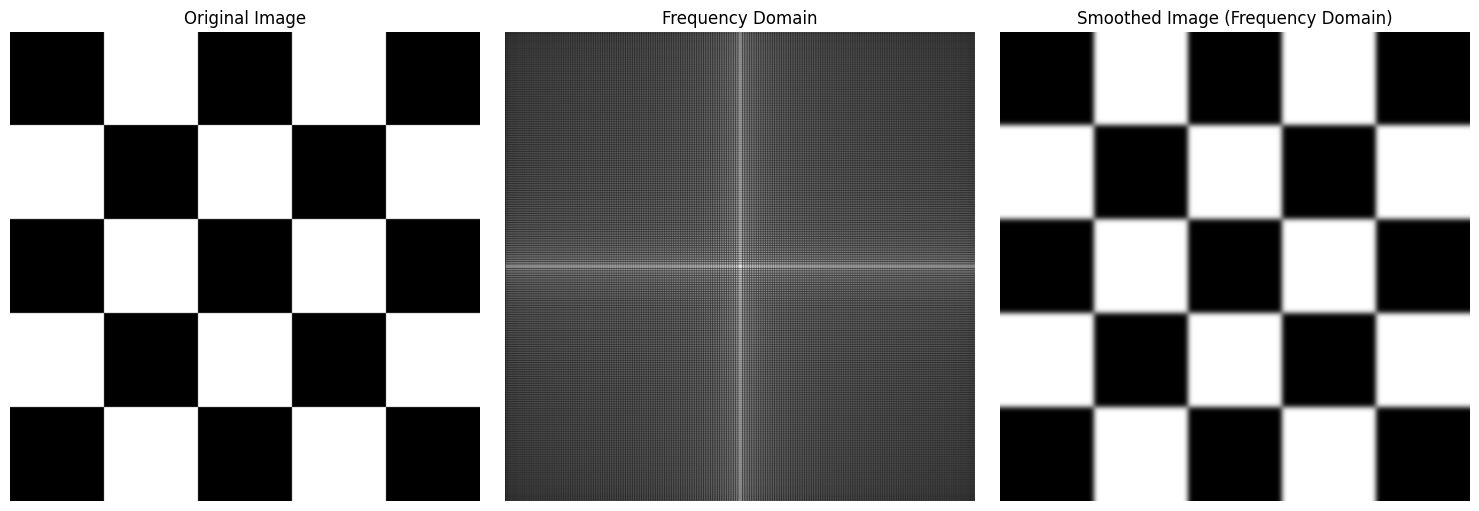

In [20]:
# Perform 2D FFT to transform the image to the frequency domain
fft_image = np.fft.fft2(image_array)
fft_shifted = np.fft.fftshift(fft_image)

# Generate a Gaussian low-pass filter
def gaussian_low_pass(shape, cutoff):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    x, y = np.ogrid[:rows, :cols]
    distance = np.sqrt((x - crow)**2 + (y - ccol)**2)
    mask = np.exp(-(distance**2) / (2 * (cutoff**2)))  # Gaussian function
    return mask

# Apply the Gaussian low-pass filter
mask = gaussian_low_pass(image_array.shape, 30)
filtered_fft = fft_shifted * mask

# Transform back to the spatial domain
ifft_shifted = np.fft.ifftshift(filtered_fft)
smoothed_image_fd = np.fft.ifft2(ifft_shifted)
smoothed_image_fd = np.abs(smoothed_image_fd)

# Display the frequency domain image (magnitude spectrum)
magnitude_spectrum = np.log1p(np.abs(fft_shifted))

# Plot the original, frequency domain, and smoothed images side by side
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Frequency domain image
plt.subplot(1, 3, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Frequency Domain')
plt.axis('off')

# Smoothed image (frequency domain filtering)
plt.subplot(1, 3, 3)
plt.imshow(smoothed_image_fd, cmap='gray')
plt.title('Smoothed Image (Frequency Domain)')
plt.axis('off')

plt.tight_layout()
plt.show()


## **2.6** Low-Pass Filter Histogram

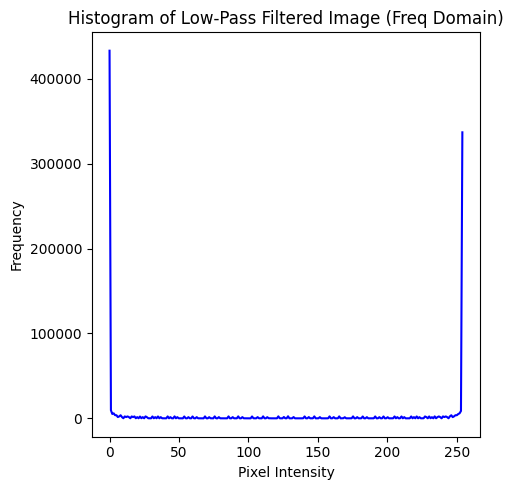

In [23]:
# Compute the histogram of the low-pass filtered image in the frequency domain
hist_freq, bin_edges_freq = np.histogram(smoothed_image_fd, bins=256, range=(0, 255))

# Plot the histogram for the frequency domain
plt.figure(figsize=(5, 5))
plt.plot(bin_edges_freq[:-1], hist_freq, color='blue')
plt.title('Histogram of Low-Pass Filtered Image (Freq Domain)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## **2.7** Uniform Probability

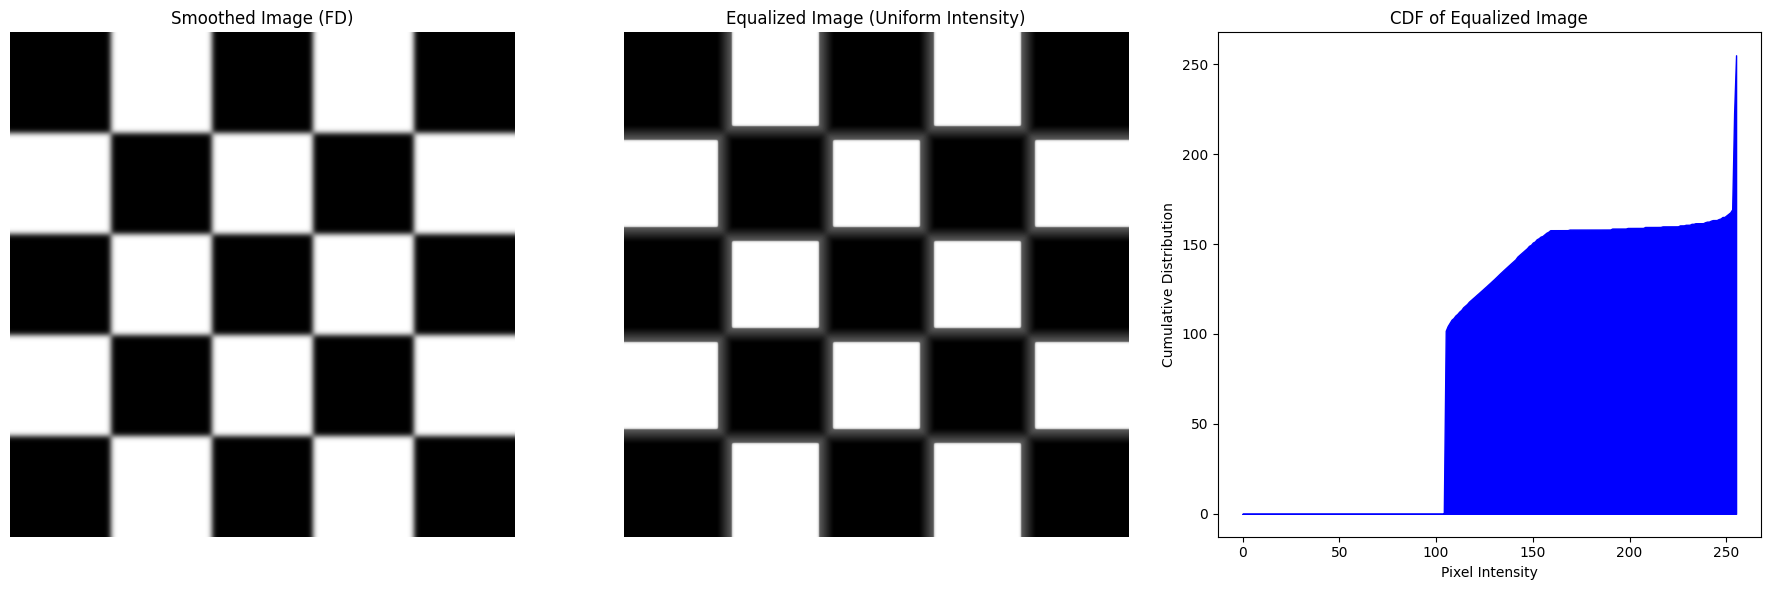

In [22]:
# Compute the histogram of the smoothed image
hist, bins = np.histogram(smoothed_image_fd.flatten(), bins=256, range=[0, 256])

# Compute the cumulative distribution function (CDF)
cdf = hist.cumsum()
cdf_normalized = cdf * 255 / cdf[-1]  # Normalize to range [0, 255]

# Use the CDF to map the original pixel values
equalized_image = np.interp(smoothed_image_fd.flatten(), bins[:-1], cdf_normalized).reshape(smoothed_image_fd.shape)

# Compute the histogram of the equalized image
hist_equalized, bins_equalized = np.histogram(equalized_image.flatten(), bins=256, range=[0, 256])

# Compute the cumulative distribution function (CDF) of the equalized image
cdf_equalized = hist_equalized.cumsum()
cdf_equalized_normalized = cdf_equalized * 255 / cdf_equalized[-1]  # Normalize to range [0, 255]

# Plot the original smoothed image, equalized image, and CDF of the equalized image in a subplot
plt.figure(figsize=(18, 6))

# Smoothed image (frequency domain filtering)
plt.subplot(1, 3, 1)
plt.imshow(smoothed_image_fd, cmap='gray')
plt.title('Smoothed Image (FD)')
plt.axis('off')

# Histogram-equalized image
plt.subplot(1, 3, 2)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image (Uniform Intensity)')
plt.axis('off')

# CDF of the equalized image
plt.subplot(1, 3, 3)
plt.fill_between(range(len(cdf_equalized_normalized)), cdf_equalized_normalized, color='blue', alpha=1)
plt.title('CDF of Equalized Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Cumulative Distribution')

plt.tight_layout()
plt.show()